**Upload Data**
digunakan untuk upload dataset csv ketika program pertama kali running. hal ini di lakukan agar tidak salah penempatan file yang akan di upload

In [4]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'files'

In [5]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def load_data(file_path):
    # Coba baca file tanpa mengasumsikan format tanggal
    df = pd.read_csv(file_path)

    print("Columns in the CSV file:", df.columns.tolist())

    # Cek apakah ada kolom yang mungkin berisi tanggal
    date_columns = df.select_dtypes(include=['object']).apply(
        lambda x: pd.to_datetime(x, errors='coerce').notnull().all())

    if 'Tanggal' in df.columns:
        df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='mixed')
        df.set_index('Tanggal', inplace=True)
    elif date_columns.any():
        date_col = date_columns[date_columns].index[0]
        print(f"Using '{date_col}' as the date column.")
        df[date_col] = pd.to_datetime(df[date_col], format='mixed')
        df.set_index(date_col, inplace=True)
    else:
        print("No date column found. Using default index.")

    return df

def check_missing_values(df):
    missing_values = df.isnull().sum()
    missing_percentages = 100 * df.isnull().sum() / len(df)
    missing_table = pd.concat([missing_values, missing_percentages], axis=1, keys=['Missing Values', 'Percentage Missing'])
    missing_table = missing_table.sort_values('Percentage Missing', ascending=False)
    missing_table = missing_table[missing_table['Missing Values'] > 0]
    return missing_table

def handle_missing_values_kmeans(df, n_clusters=5):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns

    for col in non_numeric_columns:
        df[col].fillna(df[col].mode()[0], inplace=True)

    numeric_df = df[numeric_columns]

    imputer = KNNImputer(n_neighbors=5)
    numeric_imputed = pd.DataFrame(imputer.fit_transform(numeric_df), columns=numeric_df.columns, index=numeric_df.index)

    scaler = StandardScaler()
    numeric_scaled = scaler.fit_transform(numeric_imputed)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(numeric_scaled)

    for col in numeric_columns:
        mask = numeric_df[col].isnull()
        if mask.any():
            for cluster in range(n_clusters):
                cluster_mean = numeric_imputed[col][clusters == cluster].mean()
                numeric_df.loc[mask & (clusters == cluster), col] = cluster_mean

    df[numeric_columns] = numeric_df
    return df

def save_processed_data(df, file_path):
    if isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index()
        df.rename(columns={df.columns[0]: 'Tanggal'}, inplace=True)
    if 'Tanggal' in df.columns:
        df['Tanggal'] = pd.to_datetime(df['Tanggal']).dt.strftime('%d/%m/%Y')
    df.to_csv(file_path, index=False)
    print(f"Processed data saved to {file_path}")

def main():
    input_file = 'data_2010_4.csv'
    output_file = 'data_2010_4_handled_kmeans.csv'

    df = load_data(input_file)

    print("Data shape:", df.shape)
    print("\nData types:")
    print(df.dtypes)

    print("\nMissing values before handling:")
    print(check_missing_values(df))

    df_handled = handle_missing_values_kmeans(df)

    print("\nMissing values after handling:")
    print(check_missing_values(df_handled))

    save_processed_data(df_handled, output_file)

if __name__ == "__main__":
    main()

Columns in the CSV file: ['Tanggal', 'Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ddd_x', 'ff_avg', 'ddd_car']
Data shape: (5113, 10)

Data types:
Tn         float64
Tx         float64
Tavg       float64
RH_avg     float64
RR         float64
ss         float64
ff_x       float64
ddd_x      float64
ff_avg     float64
ddd_car      int64
dtype: object

Missing values before handling:
        Missing Values  Percentage Missing
RR                 884           17.289263
RH_avg             298            5.828281
Tavg               283            5.534911
Tx                 251            4.909055
ss                 242            4.733033
Tn                 207            4.048504
ff_x               129            2.522981
ddd_x              129            2.522981
ff_avg             129            2.522981

Missing values after handling:
Empty DataFrame
Columns: [Missing Values, Percentage Missing]
Index: []
Processed data saved to data_2010_4_handled_kmeans.csv



## 1. **Impor Library**
Mengimpor pustaka yang diperlukan seperti `pandas`, `numpy`, `scikit-learn`, `tensorflow`, dan `matplotlib` untuk pemrosesan data, pembuatan model, evaluasi, dan visualisasi.

## 2. **Definisi Layer Kustom**
Membuat layer kustom bernama `ConcatenateLayer` menggunakan TensorFlow untuk menggabungkan input dari beberapa layer menjadi satu.

## 3. **Load dan Preprocessing Data**
Fungsi `load_and_preprocess_data` membaca file CSV, mengonversi kolom 'Tanggal' menjadi format datetime, dan mengatur 'Tanggal' sebagai indeks data.

## 4. **Engineering Fitur**
Fungsi `engineer_features` menambahkan fitur seperti bulan, hari, musim, hari dalam minggu, serta menghitung lag dan rolling statistics dari kolom 'RR'.

## 5. **Split Data**
Fungsi `split_data` memisahkan data menjadi data pelatihan dan pengujian dengan target kolom 'RR'.

## 6. **Skalasi Fitur**
Fungsi `scale_features` menggunakan `StandardScaler` untuk menstandarkan data fitur sebelum digunakan dalam model.


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Input, LeakyReLU, Concatenate, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import joblib
import os

class ConcatenateLayer(Layer):
    def call(self, inputs):
        return Concatenate(axis=-1)(inputs)

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')
    df.set_index('Tanggal', inplace=True)
    return df

def engineer_features(df):
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Season'] = (df.index.month % 12 + 3) // 3
    df['DayOfWeek'] = df.index.dayofweek

    for i in range(1, 8):
        df[f'RR_Lag_{i}'] = df['RR'].shift(i)

    df['RR_Rolling_Mean_7'] = df['RR'].rolling(window=7).mean()
    df['RR_Rolling_Std_7'] = df['RR'].rolling(window=7).std()
    df['RR_Rolling_Max_7'] = df['RR'].rolling(window=7).max()

    return df.dropna()

def split_data(df, target_col='RR', test_size=0.2):
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=42)

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

ModuleNotFoundError: No module named 'tensorflow.python'

In [4]:
df = load_and_preprocess_data('data_2010_4_handled_kmeans.csv')
df = engineer_features(df)

X_train, X_test, y_train, y_test = split_data(df)
X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")

X_train_scaled shape: (4084, 23)
y_train shape: (4084,)


In [5]:
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print("CNN Model Summary:")
    model.summary()
    return model

def create_gan_model(input_shape):
    def build_generator():
        gen_input = Input(shape=input_shape)
        x = Dense(128)(gen_input)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        gen_output = Dense(1, activation='linear')(x)
        return Model(gen_input, gen_output, name='generator')

    def build_discriminator():
        disc_input = Input(shape=(input_shape[0] + 1,))
        x = Dense(512)(disc_input)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(128)(x)
        x = LeakyReLU(alpha=0.2)(x)
        disc_output = Dense(1, activation='sigmoid')(x)
        return Model(disc_input, disc_output, name='discriminator')

    generator = build_generator()
    discriminator = build_discriminator()

    gan_input = Input(shape=input_shape)
    generated_rainfall = generator(gan_input)
    concat_layer = ConcatenateLayer()
    concatenated = concat_layer([gan_input, generated_rainfall])
    gan_output = discriminator(concatenated)

    gan = Model(gan_input, [generated_rainfall, gan_output], name='gan')

    return gan, generator, discriminator

def train_cnn(X_train, y_train, epochs=200, batch_size=32, patience=10):
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    model = create_cnn_model((X_train.shape[1], 1))

    history = model.fit(
        X_train_reshaped, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return model, history

def train_ensemble(X_train, y_train, epochs=100, batch_size=32, patience=10):
    # Train CNN
    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    cnn_model, cnn_history = train_cnn(X_train_reshaped, y_train, epochs, batch_size, patience)

    # Train Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Train GAN
    gan_model, generator, discriminator = create_gan_model((X_train.shape[1],))
    gan_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

    gan_model.compile(optimizer=gan_optimizer, loss=['mse', 'binary_crossentropy'])
    discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
    generator.compile(optimizer=generator_optimizer, loss='mse')

    for epoch in range(epochs):
        for _ in range(5):  # Train discriminator more frequently
            noise = np.random.normal(0, 1, (batch_size, X_train.shape[1]))
            generated_rainfall = generator.predict(noise)

            # Use .iloc for positional indexing and .values to get numpy array
            real_indices = np.random.randint(0, len(y_train), batch_size)
            real_rainfall = y_train.iloc[real_indices].values.reshape(-1, 1)

            real_input = np.concatenate([noise, real_rainfall], axis=1)
            fake_input = np.concatenate([noise, generated_rainfall], axis=1)

            d_loss_real = discriminator.train_on_batch(real_input, np.ones((batch_size, 1)))
            d_loss_fake = discriminator.train_on_batch(fake_input, np.zeros((batch_size, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, X_train.shape[1]))
        g_loss = gan_model.train_on_batch(noise, [np.ones((batch_size, 1)), np.ones((batch_size, 1))])

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss}, G Loss: {g_loss}")

    return cnn_model, rf_model, generator, cnn_history


def ensemble_predict(X, cnn_model, rf_model, gan_generator):
    X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
    cnn_pred = cnn_model.predict(X_reshaped).flatten()
    rf_pred = rf_model.predict(X)
    gan_pred = gan_generator.predict(X).flatten()

    # Simple averaging of predictions
    ensemble_pred = (cnn_pred + rf_pred + gan_pred) / 3
    return ensemble_pred

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('CNN Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('cnn_model_loss.png')
    plt.close()


def get_random_samples(X, y, n_samples=50):
    if len(X) > n_samples:
        indices = np.random.choice(len(X), n_samples, replace=False)
        return X.iloc[indices], y.iloc[indices]
    else:
        return X, y

def save_ensemble_models(cnn_model, rf_model, gan_generator, scaler,
                         cnn_path='cnn_model.keras', rf_path='rf_model.joblib',
                         gan_path='gan_generator.keras', scaler_path='ensemble_scaler.joblib'):
    # Save CNN model
    cnn_model.save(cnn_path)

    # Save Random Forest model
    joblib.dump(rf_model, rf_path)

    # Save GAN generator
    gan_generator.save(gan_path)

    # Save scaler
    joblib.dump(scaler, scaler_path)

    print("Ensemble models and scaler successfully saved.")


In [6]:


cnn_model, rf_model, gan_generator, history = train_ensemble(X_train_scaled, y_train)

plot_history(history)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 21, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 8, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           6,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,933 (50.52 KB)

 Trainable params: 12,933 (50.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 214.2694 - val_loss: 206.3751 - learning_rate: 0.0010
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 153.6783 - val_loss: 183.5993 - learning_rate: 0.0010
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 150.6101 - val_loss: 158.2268 - learning_rate: 0.0010
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 127.6202 - val_loss: 139.4531 - learning_rate: 0.0010
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 123.5525 - val_loss: 110.0067 - learning_rate: 0.0010
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 99.9468 - val_loss: 87.3117 - learning_rate: 0.0010
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 90.3217 - val_loss: 79.3000 - learning_rate: 0.0010
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 74.1541 - val_loss: 59.0202 - learning_rate: 0.0010
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 64.7975 - val_loss: 48.93

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 0, D Loss: 0.6884487271308899, G Loss: [array(0.6891352, dtype=float32), array(0.6891352, dtype=float32), array(0.6891352, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━

In [7]:
save_ensemble_models(cnn_model, rf_model, gan_generator, scaler)

Ensemble models and scaler successfully saved.


In [14]:
pip install table-evaluator==1.2.2.post1

In [15]:
pip install --upgrade scipy

In [16]:
def load_ensemble_models(cnn_path='cnn_model.keras', rf_path='rf_model.joblib',
                         gan_path='gan_generator.keras', scaler_path='ensemble_scaler.joblib'):
    # Load CNN model
    cnn_model = tf.keras.models.load_model(cnn_path)

    # Load Random Forest model
    rf_model = joblib.load(rf_path)

    # Load GAN generator
    gan_generator = tf.keras.models.load_model(gan_path)

    # Load scaler
    scaler = joblib.load(scaler_path)

    print("Ensemble models and scaler successfully loaded.")
    return cnn_model, rf_model, gan_generator, scaler

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from table_evaluator import TableEvaluator
from scipy.stats import pearsonr

class UpdatedTableEvaluator(TableEvaluator):
    def _get_columns(self):
        if self.categorical_columns or self.numerical_columns:
            return self.categorical_columns + self.numerical_columns
        else:
            return self.real.columns.tolist()

    def plot_distributions(self):
        columns = self._get_columns()
        fig, axes = plt.subplots(len(columns), figsize=(20, 5*len(columns)))
        if len(columns) == 1:
            axes = [axes]
        for i, col in enumerate(columns):
            sns.histplot(self.real[col], ax=axes[i], label='Real', kde=True)
            sns.histplot(self.fake[col], ax=axes[i], label='Fake', kde=True)
            axes[i].set_title(f'{col} distribution in real and fake data')
            axes[i].legend()
        plt.tight_layout()
        plt.show()

    def compute_correlation(self, data):
        corr_matrix = np.zeros((data.shape[1], data.shape[1]))
        for i in range(data.shape[1]):
            for j in range(data.shape[1]):
                if i != j:
                    corr, _ = pearsonr(data.iloc[:, i], data.iloc[:, j])
                    corr_matrix[i, j] = corr
                else:
                    corr_matrix[i, j] = 1.0
        return pd.DataFrame(corr_matrix, index=data.columns, columns=data.columns)

    def plot_correlation_difference(self, plot_diff=True, **kwargs):
        def plot_correlation(data, ax, title):
            corr = self.compute_correlation(data)
            sns.heatmap(corr, ax=ax, cmap='coolwarm', center=0, **kwargs)
            ax.set_title(title)

        if plot_diff:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
            plot_correlation(self.real, ax1, 'Real data correlation')
            plot_correlation(self.fake, ax2, 'Fake data correlation')
            diff = self.compute_correlation(self.fake) - self.compute_correlation(self.real)
            sns.heatmap(diff, ax=ax3, cmap='coolwarm', center=0, **kwargs)
            ax3.set_title('Correlation difference')
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
            plot_correlation(self.real, ax1, 'Real data correlation')
            plot_correlation(self.fake, ax2, 'Fake data correlation')
        plt.tight_layout()
        plt.show()
def generate_synthetic_samples(X, cnn_model, rf_model, gan_generator, n_samples):
    synthetic_X = np.random.normal(X.mean(), X.std(), (n_samples, X.shape[1]))
    synthetic_y = ensemble_predict(synthetic_X, cnn_model, rf_model, gan_generator)
    return pd.DataFrame(synthetic_X, columns=X.columns), pd.Series(synthetic_y, name='RR')


def main():
    # Load and preprocess the real data
    df = load_and_preprocess_data('data_2010_4.csv')
    df = engineer_features(df)

    # Split features and target
    X = df.drop('RR', axis=1)
    y = df['RR']

    # Load the ensemble models
    cnn_model, rf_model, gan_generator, scaler = load_ensemble_models()

    # Generate synthetic samples
    n_samples = len(df)  # Generate the same number of samples as in the original dataset
    synthetic_X, synthetic_y = generate_synthetic_samples(X, cnn_model, rf_model, gan_generator, n_samples)

    # Combine synthetic features and target
    synthetic_df = pd.concat([synthetic_X, synthetic_y], axis=1)

    # Reset index of real samples
    df = df.reset_index(drop=True)

    # Create UpdatedTableEvaluator object
    table_evaluator = UpdatedTableEvaluator(df, synthetic_df)

    # Perform evaluations
    table_evaluator.visual_evaluation()
    print("\nStatistical evaluation:")
    table_evaluator.statistical_evaluation()
    print("\nMachine learning evaluation:")
    # table_evaluator.machine_learning_evaluation()

    # Get an overall quality score
    # quality_score = table_evaluator.evaluate(target_col='RR')
    # print(f"\nOverall quality score: {quality_score}")

if __name__ == "__main__":
    main()

ImportError: cannot import name 'is_jax' from 'scipy._lib._array_api' (/usr/local/lib/python3.10/dist-packages/scipy/_lib/_array_api.py)

In [19]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(12, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted Rainfall (Tuned Ensemble)')
    plt.savefig('tuned_ensemble_results.png')
    plt.close()
def apply_threshold(predictions, threshold=0.5):
    return np.where(predictions < threshold, 0, predictions)

In [24]:
cnn_model, rf_model, gan_generator, scaler = load_ensemble_models()
if cnn_model is None or rf_model is None or gan_generator is None or scaler is None:
    print("Failed to load ensemble models. Exiting the program.")


df = load_and_preprocess_data('data_2010_4.csv')
df = engineer_features(df)
X, y = df.drop('RR', axis=1), df['RR']
X_scaled = scaler.transform(X)
X_test, y_test = pd.DataFrame(X_scaled, index=X.index, columns=X.columns), y

X_test_sample, y_test_sample = get_random_samples(X_test, y_test, n_samples=50)

predictions = ensemble_predict(X_test_sample.values, cnn_model, rf_model, gan_generator)

threshold = 3
predictions_thresholded = apply_threshold(predictions, threshold)

mse, mae, r2 = evaluate_model(y_test_sample, predictions_thresholded)
print(f"\nEnsemble Model Evaluation (with {threshold} mm threshold):")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")

print("\nPredictions vs actual values (with threshold):")
for i in range(len(predictions)):
  print(f"Date: {y_test_sample.index[i].strftime('%Y-%m-%d')}, "
        f"Prediction: {predictions_thresholded[i]:.2f}, "
        f"Prediction (without threshold): {predictions[i]:.2f}, "
        f"Actual: {y_test_sample.iloc[i]:.2f}")

print("\nAdditional Statistics (with threshold):")
print(f"Mean prediction: {np.mean(predictions_thresholded):.2f}")
print(f"Mean actual: {np.mean(y_test_sample):.2f}")
print(f"Median prediction: {np.median(predictions_thresholded):.2f}")
print(f"Median actual: {np.median(y_test_sample):.2f}")
print(f"Standard deviation of predictions: {np.std(predictions_thresholded):.2f}")
print(f"Standard deviation of actual values: {np.std(y_test_sample):.2f}")

y_test_binary = (y_test_sample > threshold).astype(int)
predictions_binary = (predictions_thresholded > threshold).astype(int)
accuracy = (y_test_binary == predictions_binary).mean()
print(f"\nRain/No Rain Classification Accuracy (Ensemble): {accuracy:.4f}")

plot_predictions(y_test_sample, predictions_thresholded)

Ensemble models and scaler successfully loaded.
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Ensemble Model Evaluation (with 3 mm threshold):
Mean Squared Error: 45.0702
Mean Absolute Error: 3.3780
R-squared Score: 0.7930

Predictions vs actual values (with threshold):
Date: 2012-06-02, Prediction: 0.00, Prediction (without threshold): 0.79, Actual: 0.00
Date: 2011-09-02, Prediction: 0.00, Prediction (without threshold): 0.46, Actual: 0.00
Date: 2018-09-05, Prediction: 0.00, Prediction (without threshold): 0.17, Actual: 0.00
Date: 2018-06-30, Prediction: 0.00, Prediction (without threshold): 1.99, Actual: 0.00
Date: 2017-10-30, Prediction: 22.42, Prediction (without threshold): 22.42, Actual: 30.00
Date: 2012-11-11, Prediction: 0.00, Prediction (without threshold): 1.17, Actual: 0.00
Date: 2011-11-08, Prediction: 0.00, Prediction (without threshold): 0.52, Actual: 0.00
Date: 2022-10-20, Prediction: 5.28, Prediction (without threshold): 5.28, Actual: 0.00
Date: 2017-03-17, Prediction: 0.00, Prediction 

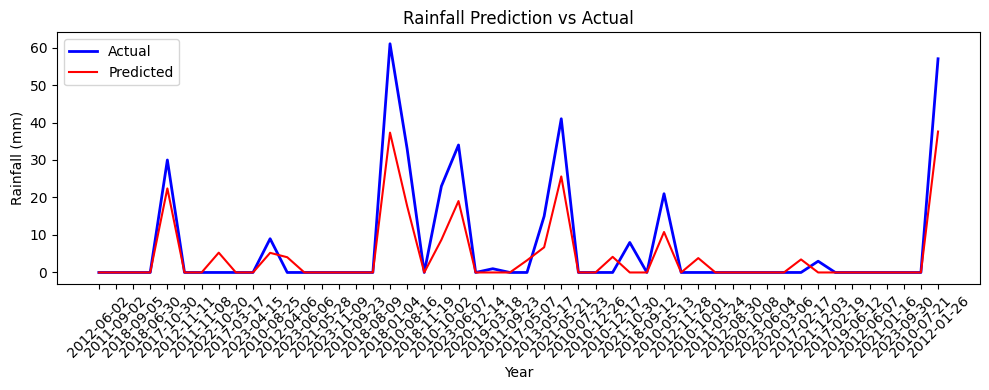

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming predictions, predictions_thresholded, and y_test_sample are already defined
# For example purposes, I'm assuming y_test_sample.index is a time-based index

# Prepare data for plotting
data = {
    'Tanggal': [y_test_sample.index[i].strftime('%Y-%m-%d') for i in range(len(predictions))],
    'Prediksi': [predictions_thresholded[i] for i in range(len(predictions))],
    'Aktual': [y_test_sample.iloc[i] for i in range(len(predictions))]
}

# Create a DataFrame for better control over data
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(df['Tanggal'], df['Aktual'], label='Actual', color='blue', linewidth=2)
plt.plot(df['Tanggal'], df['Prediksi'], label='Predicted', color='red', linewidth=1.5)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Prediction vs Actual')

# Add a legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


Ensemble models and scaler successfully loaded.


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


NameError: name 'generate_synthetic_samples' is not defined

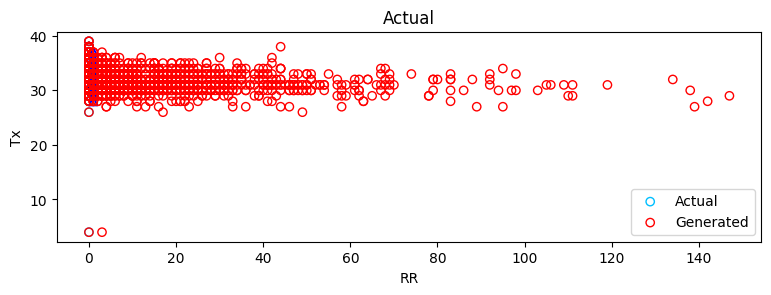

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
import joblib

# [Fungsi-fungsi yang sudah ada sebelumnya tetap sama]

def plot_comparison(real_data, generated_data, ax, title):
    col1, col2 = 'RR', 'Tx'  # Rainfall dan Max Temperature
    colors = ['deepskyblue', 'blue']
    markers = ['o', '^']

    # Plot data asli
    for group, color, marker in zip(real_data.groupby('RR'), colors, markers):
        ax.scatter(group[1][[col1]], group[1][[col2]],
                   marker=marker, edgecolors=color, facecolors='none', label='Actual' if color == colors[0] else '')

    # Plot data yang dihasilkan
    ax.scatter(generated_data[[col1]], generated_data[[col2]],
               marker='o', edgecolors='red', facecolors='none', label='Generated')

    ax.set_title(title)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.legend()

def main():
    # Load and preprocess the real data
    df = load_and_preprocess_data('data_2010_4.csv')
    df = engineer_features(df)

    # Split features and target
    X = df.drop('RR', axis=1)
    y = df['RR']

    # Load the ensemble models
    cnn_model, rf_model, gan_generator, scaler = load_ensemble_models()

    # Setup visualization parameters
    seed = 17
    test_size = 128
    noise_dim = X.shape[1]  # Use the same dimension as our input features

    np.random.seed(seed)
    z = np.random.normal(size=(test_size, noise_dim))

    model_steps = [0, 100]
    rows = len(model_steps)
    columns = 2  # Actual and Generated

    fig = plt.figure(figsize=(20, rows*3))

    for model_step_ix, model_step in enumerate(model_steps):
        # Plot actual data
        ax_actual = plt.subplot(rows, columns, model_step_ix*columns + 1)
        plot_comparison(df, df, ax_actual, 'Actual')

        # Generate and plot synthetic data
        synthetic_X, synthetic_y = generate_synthetic_samples(X, cnn_model, rf_model, gan_generator, test_size)
        synthetic_df = pd.concat([synthetic_X, synthetic_y], axis=1)

        ax_generated = plt.subplot(rows, columns, model_step_ix*columns + 2)
        plot_comparison(df, synthetic_df, ax_generated, f'Generated (Step {model_step})')

    plt.suptitle('Comparison of Ensemble Model Outputs', size=16, fontweight='bold')
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])

    # Adding text labels for training steps
    axarr = fig.get_axes()
    vpositions = np.array([ax._position.bounds[1] for ax in axarr[::2]])  # Only every other axis (actual data)
    vpositions += ((vpositions[0] - vpositions[1]) * 0.35)
    for model_step_ix, model_step in enumerate(model_steps):
        fig.text(0.02, vpositions[model_step_ix], f'training\nstep\n{model_step}',
                 ha='center', va='center', size=12)

    plt.savefig('Comparison_of_Ensemble_outputs.png')
    plt.show()

if __name__ == "__main__":
    main()

In [29]:
# File: ensemble_tuning.py

import pandas as pd
import numpy as np
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from scipy.stats import randint, uniform
import tensorflow as tf
import joblib

# [Fungsi load_and_preprocess_data dan engineer_features tetap sama]

def create_cnn_model(input_shape, learning_rate=0.001, filters=64, kernel_size=3, pool_size=2):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=pool_size),
        Conv1D(filters=filters//2, kernel_size=kernel_size, activation='relu'),
        MaxPooling1D(pool_size=pool_size),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def tune_cnn(X_train, y_train, X_val, y_val):
    print("\nTuning CNN model...")
    best_mse = float('inf')
    best_model = None
    best_params = {}

    for i in range(20):  # Jumlah iterasi pencarian
        print(f"\nCNN Tuning Iteration {i+1}/20")
        learning_rate = np.random.uniform(0.0001, 0.01)
        filters = np.random.randint(32, 128)
        kernel_size = np.random.randint(2, 5)
        pool_size = np.random.randint(2, 4)
        batch_size = np.random.choice([32, 64, 128])
        epochs = np.random.choice([50, 100, 150])

        print(f"Parameters: LR={learning_rate:.4f}, Filters={filters}, Kernel={kernel_size}, Pool={pool_size}, Batch={batch_size}, Epochs={epochs}")

        model = create_cnn_model(
            input_shape=(X_train.shape[1], 1),
            learning_rate=learning_rate,
            filters=filters,
            kernel_size=kernel_size,
            pool_size=pool_size
        )

        history = model.fit(
            X_train.reshape(X_train.shape[0], X_train.shape[1], 1),
            y_train,
            validation_data=(X_val.reshape(X_val.shape[0], X_val.shape[1], 1), y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        mse = model.evaluate(X_val.reshape(X_val.shape[0], X_val.shape[1], 1), y_val, verbose=0)
        print(f"Validation MSE: {mse:.4f}")

        if mse < best_mse:
            best_mse = mse
            best_model = model
            best_params = {
                'learning_rate': learning_rate,
                'filters': filters,
                'kernel_size': kernel_size,
                'pool_size': pool_size,
                'batch_size': batch_size,
                'epochs': epochs
            }
            print("New best model found!")

    print("\nBest CNN parameters:", best_params)
    print(f"Best CNN validation MSE: {best_mse:.4f}")
    return best_model

def tune_random_forest(X_train, y_train):
    print("\nTuning Random Forest model...")
    rf = RandomForestRegressor()
    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(5, 50),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': uniform(0.1, 0.9)
    }
    random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                       n_iter=20, cv=3, random_state=42, n_jobs=-1, verbose=2)
    random_search.fit(X_train, y_train)
    print("\nBest Random Forest parameters:", random_search.best_params_)
    print(f"Best Random Forest CV score: {random_search.best_score_:.4f}")
    return random_search.best_estimator_

def create_gan_generator(input_dim, output_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dense(256, activation='relu'),
        Dense(512, activation='relu'),
        Dense(output_dim, activation='linear')
    ])
    return model

def tune_gan(X_train, y_train):
    print("\nTuning GAN model...")
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1
    generator = create_gan_generator(input_dim, output_dim)
    generator.compile(optimizer=Adam(learning_rate=0.0002), loss='mse')

    print("Training GAN generator...")
    history = generator.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

    print(f"Final GAN generator loss: {history.history['loss'][-1]:.4f}")
    return generator

def train_and_tune_ensemble(X_train, y_train, X_val, y_val):
    cnn_model = tune_cnn(X_train, y_train, X_val, y_val)
    rf_model = tune_random_forest(X_train, y_train)
    gan_generator = tune_gan(X_train, y_train)
    return cnn_model, rf_model, gan_generator

def save_tuned_models(cnn_model, rf_model, gan_generator, scaler):
    save_model(cnn_model, 'tuned_cnn_model.keras')
    joblib.dump(rf_model, 'tuned_rf_model.joblib')
    save_model(gan_generator, 'tuned_gan_generator.keras')
    joblib.dump(scaler, 'tuned_scaler.joblib')


if __name__ == "__main__":
    print("Loading and preprocessing data...")
    df = load_and_preprocess_data('data_2010_4_handled_kmeans.csv')
    df = engineer_features(df)

    print("Splitting data...")
    X = df.drop('RR', axis=1)
    y = df['RR']
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print("Starting ensemble model tuning...")
    cnn_model, rf_model, gan_generator = train_and_tune_ensemble(X_train_scaled, y_train, X_val_scaled, y_val)




Loading and preprocessing data...
Splitting data...
Scaling features...
Starting ensemble model tuning...

Tuning CNN model...

CNN Tuning Iteration 1/20
Parameters: LR=0.0033, Filters=102, Kernel=2, Pool=3, Batch=128, Epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 72.9831
New best model found!

CNN Tuning Iteration 2/20
Parameters: LR=0.0065, Filters=47, Kernel=3, Pool=3, Batch=128, Epochs=150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 216.4636

CNN Tuning Iteration 3/20
Parameters: LR=0.0098, Filters=81, Kernel=4, Pool=3, Batch=64, Epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 142.5536

CNN Tuning Iteration 4/20
Parameters: LR=0.0041, Filters=112, Kernel=4, Pool=2, Batch=32, Epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 32.9554
New best model found!

CNN Tuning Iteration 5/20
Parameters: LR=0.0071, Filters=69, Kernel=3, Pool=2, Batch=32, Epochs=150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 18.5545
New best model found!

CNN Tuning Iteration 6/20
Parameters: LR=0.0018, Filters=105, Kernel=4, Pool=3, Batch=128, Epochs=150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 79.9168

CNN Tuning Iteration 7/20
Parameters: LR=0.0042, Filters=97, Kernel=4, Pool=3, Batch=32, Epochs=150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 90.8296

CNN Tuning Iteration 8/20
Parameters: LR=0.0067, Filters=93, Kernel=2, Pool=2, Batch=128, Epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 16.4067
New best model found!

CNN Tuning Iteration 9/20
Parameters: LR=0.0016, Filters=44, Kernel=3, Pool=2, Batch=64, Epochs=150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 13.7715
New best model found!

CNN Tuning Iteration 10/20
Parameters: LR=0.0098, Filters=120, Kernel=2, Pool=3, Batch=32, Epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 73.2393

CNN Tuning Iteration 11/20
Parameters: LR=0.0100, Filters=57, Kernel=2, Pool=2, Batch=128, Epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 20.4038

CNN Tuning Iteration 12/20
Parameters: LR=0.0023, Filters=86, Kernel=2, Pool=2, Batch=128, Epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 13.2775
New best model found!

CNN Tuning Iteration 13/20
Parameters: LR=0.0018, Filters=56, Kernel=3, Pool=3, Batch=64, Epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 201.3228

CNN Tuning Iteration 14/20
Parameters: LR=0.0050, Filters=109, Kernel=4, Pool=3, Batch=32, Epochs=150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 116.3179

CNN Tuning Iteration 15/20
Parameters: LR=0.0065, Filters=43, Kernel=2, Pool=3, Batch=128, Epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 72.9754

CNN Tuning Iteration 16/20
Parameters: LR=0.0037, Filters=118, Kernel=2, Pool=3, Batch=128, Epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 68.7589

CNN Tuning Iteration 17/20
Parameters: LR=0.0071, Filters=45, Kernel=2, Pool=3, Batch=64, Epochs=150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 78.0046

CNN Tuning Iteration 18/20
Parameters: LR=0.0088, Filters=97, Kernel=2, Pool=3, Batch=32, Epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 78.1791

CNN Tuning Iteration 19/20
Parameters: LR=0.0055, Filters=119, Kernel=4, Pool=3, Batch=32, Epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 120.4537

CNN Tuning Iteration 20/20
Parameters: LR=0.0027, Filters=123, Kernel=4, Pool=2, Batch=32, Epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation MSE: 25.6278

Best CNN parameters: {'learning_rate': 0.002276201998224947, 'filters': 86, 'kernel_size': 2, 'pool_size': 2, 'batch_size': 128, 'epochs': 100}
Best CNN validation MSE: 13.2775

Tuning Random Forest model...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()



Best Random Forest parameters: {'max_depth': 48, 'max_features': 0.9446974381141752, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 413}
Best Random Forest CV score: 0.4949

Tuning GAN model...
Training GAN generator...
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 179.9393
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 146.4758
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 96.1393
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 54.3738
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 34.0164
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 24.8127
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.5519
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.6002
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 13.2555
Epoch 10/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10.2528
Epoch 11/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4757
Epoch 12/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.1706
Epoch 13/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.6231
Epoch 14/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 6.3073
Epoch 15/100
112/112 ━━━━━━━━━━━━━━━

In [31]:
from tensorflow.keras.models import Sequential, save_model

print("Saving tuned models...")
save_tuned_models(cnn_model, rf_model, gan_generator, scaler)

print("Tuning completed and models saved.")

Saving tuned models...
Tuning completed and models saved.


In [44]:
# File: test_tuned_ensemble_adapted.py

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import joblib
import matplotlib.pyplot as plt

def load_preprocess_data_tuned(file_path):
    df = pd.read_csv(file_path)
    df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')
    df.set_index('Tanggal', inplace=True)
    return df

def engineer_features_tuned(df):
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Season'] = (df.index.month % 12 + 3) // 3
    df['DayOfWeek'] = df.index.dayofweek

    for i in range(1, 8):
        df[f'RR_Lag_{i}'] = df['RR'].shift(i)

    df['RR_Rolling_Mean_7'] = df['RR'].rolling(window=7).mean()
    df['RR_Rolling_Std_7'] = df['RR'].rolling(window=7).std()
    df['RR_Rolling_Max_7'] = df['RR'].rolling(window=7).max()

    return df.dropna()

def load_tuned_models():
    try:
        cnn_model_tuned = load_model('tuned_cnn_model.keras')
        rf_model_tuned = joblib.load('tuned_rf_model.joblib')
        gan_generator_tuned = load_model('tuned_gan_generator.keras')
        scaler_tuned = joblib.load('tuned_scaler.joblib')
        return cnn_model_tuned, rf_model_tuned, gan_generator_tuned, scaler_tuned
    except:
        return None, None, None, None

def ensemble_predict_tuned(X, cnn_model_tuned, rf_model_tuned, gan_generator_tuned):
    X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
    cnn_pred = cnn_model_tuned.predict(X_reshaped).flatten()
    rf_pred = rf_model_tuned.predict(X)
    gan_pred = gan_generator_tuned.predict(X).flatten()
    ensemble_pred = (cnn_pred + rf_pred + gan_pred) / 3
    return ensemble_pred

def evaluate_model_tuned(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

def plot_predictions_tuned(y_true, y_pred):
    plt.figure(figsize=(12, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted Rainfall (Tuned Ensemble)')
    plt.savefig('tuned_ensemble_results.png')
    plt.close()

def get_random_samples_tuned(X, y, n_samples=100):
    if len(X) > n_samples:
        indices = np.random.choice(len(X), n_samples, replace=False)
        return X.iloc[indices], y.iloc[indices]
    else:
        return X, y

def apply_threshold_tuned(predictions, threshold=0.5):
    return np.where(predictions < threshold, 0, predictions)

if __name__ == "__main__":
    cnn_model_tuned, rf_model_tuned, gan_generator_tuned, scaler_tuned = load_tuned_models()
    if cnn_model_tuned is None or rf_model_tuned is None or gan_generator_tuned is None or scaler_tuned is None:
        print("Failed to load tuned ensemble models. Exiting the program.")
        exit()

    df_tuned = load_preprocess_data_tuned('data_2010_4.csv')
    df_tuned = engineer_features_tuned(df_tuned)
    X_tuned, y_tuned = df_tuned.drop('RR', axis=1), df_tuned['RR']
    X_scaled_tuned = scaler_tuned.transform(X_tuned)
    X_test_tuned, y_test_tuned = pd.DataFrame(X_scaled_tuned, index=X_tuned.index, columns=X_tuned.columns), y_tuned

    X_test_sample_tuned, y_test_sample_tuned = get_random_samples_tuned(X_test_tuned, y_test_tuned, n_samples=50)

    predictions_tuned = ensemble_predict_tuned(X_test_sample_tuned.values, cnn_model_tuned, rf_model_tuned, gan_generator_tuned)

    threshold = 3
    predictions_thresholded_tuned = apply_threshold_tuned(predictions_tuned, threshold)

    mse_tuned, mae_tuned, r2_tuned = evaluate_model_tuned(y_test_sample_tuned, predictions_thresholded_tuned)
    print(f"\nTuned Ensemble Model Evaluation (with {threshold} mm threshold):")
    print(f"Mean Squared Error: {mse_tuned:.4f}")
    print(f"Mean Absolute Error: {mae_tuned:.4f}")
    print(f"R-squared Score: {r2_tuned:.4f}")

    print("\nPredictions vs actual values (with threshold):")
    for i in range(len(predictions_tuned)):
        print(f"Date: {y_test_sample_tuned.index[i].strftime('%Y-%m-%d')}, "
              f"Prediction: {predictions_thresholded_tuned[i]:.2f}, "
              f"Prediction (without threshold): {predictions_tuned[i]:.2f}, "
              f"Actual: {y_test_sample_tuned.iloc[i]:.2f}")

    print("\nAdditional Statistics (with threshold):")
    print(f"Mean prediction: {np.mean(predictions_thresholded_tuned):.2f}")
    print(f"Mean actual: {np.mean(y_test_sample_tuned):.2f}")
    print(f"Median prediction: {np.median(predictions_thresholded_tuned):.2f}")
    print(f"Median actual: {np.median(y_test_sample_tuned):.2f}")
    print(f"Standard deviation of predictions: {np.std(predictions_thresholded_tuned):.2f}")
    print(f"Standard deviation of actual values: {np.std(y_test_sample_tuned):.2f}")

    y_test_binary_tuned = (y_test_sample_tuned > threshold).astype(int)
    predictions_binary_tuned = (predictions_thresholded_tuned > threshold).astype(int)
    accuracy_tuned = (y_test_binary_tuned == predictions_binary_tuned).mean()
    print(f"\nRain/No Rain Classification Accuracy (Tuned Ensemble): {accuracy_tuned:.4f}")

    plot_predictions_tuned(y_test_sample_tuned, predictions_thresholded_tuned)

    print("\nTesting of tuned ensemble model completed. Results saved as 'tuned_ensemble_results.png'.")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Tuned Ensemble Model Evaluation (with 3 mm threshold):
Mean Squared Error: 6.1234
Mean Absolute Error: 1.4911
R-squared Score: 0.9886

Predictions vs actual values (with threshold):
Date: 2022-09-16, Prediction: 0.00, Prediction (without threshold): 2.75, Actual: 2.00
Date: 2023-03-21, Prediction: 6.69, Prediction (without threshold): 6.69, Actual: 8.00
Date: 2011-02-20, Prediction: 0.00, Prediction (without threshold): 1.15, Actual: 0.00
Date: 2021-11-24, Prediction: 3.25, Prediction (without threshold): 3.25, Actual: 4.00
Date: 2023-07-30, Prediction: 0.00, Prediction (without threshold): -0.08, Actual: 0.00
Date: 2019-02-23, Prediction: 3.86, Prediction (without threshold): 3.86, Actual: 2.00
Date: 2013-01-24, Prediction: 20.53, Prediction (without threshold): 20.53, Actual: 22.00
Date: 2023-02-23, Prediction: 13.87, Prediction (without threshold): 13.87, Actual: 14.00
Date: 2020-01-06, Prediction: 16.61, P